<a href="https://colab.research.google.com/github/ssubbinn/ESAA-OB/blob/main/1%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3. 분류


### 3.1 MNIST

MNIST 데이터셋 : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지


In [1]:
#MNIST 내려받는 코드
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1, as_frame=False) #as_frame=False 지정해야 X[0] 돌아감
mnist.keys()
#DESCR -> 데이터셋 설명
#data -> 샘플이 하나의 행, 특성이 하나의 열
#target -> 레이블 배열

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y=mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

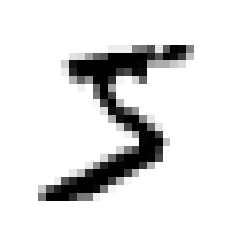

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
#실제 레이블 확인
y[0]

'5'

In [6]:
#레이블을 문자열에서 정수로 변환
import numpy as np
y=y.astype(np.uint8)

In [7]:
#테스트 세트와 훈련 세트 나누기
#앞 60000개는 훈련세트, 뒤 10000개는 테스트 세트
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

### 3.2 이진 분류기 훈련

ex) 숫자 5를 식별할때, 5인지 아닌지 분류 (이진 분류기)

In [8]:
y_train_5 = (y_train == 5) #5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [9]:
#SGD(확률적 경사 하강법)분류기 이용하여 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
#모델을 이용해 숫자 5 이미지 감지
sgd_clf.predict([some_digit])
#맞춤

array([ True])

### 3.3 성능 측정

3.3.1 교차 검증을 사용한 정확도 측정

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
#cross_val_score()이용하여 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#정확도가 95%이상

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#정확도 90%이상 -> 원데이터의 10%가 5가 아니므로 당연한 결과

array([0.91125, 0.90855, 0.90915])

3.3.2 오차 행렬

: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는것

ex) 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨

In [15]:
#cross_val_predict() 함수 -> k겹 고차 검증 수행하고 각 테스트 폴드에서 얻은 예측 반환
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬의 

행-> 실제 클래스, 열-> 예측한 클래스


In [17]:
#완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

<다른지표>
1. 정밀도 : 양성 예측의 정확도
2. 재현율 : 정밀도와 같이 사용되는 지표. 민감도 또는 진짜 양성 비율


3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
#f1 score -> 항상 좋은건 아님
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

3.3.4 정밀도/재현율 트레이드오프

In [21]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold=0 #임곗값
y_some_digit_pred = (y_scores > threshold)

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#임곗값을 높였더니 분류기가 놓침

array([False])

In [24]:
# 적절한 임곗값 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

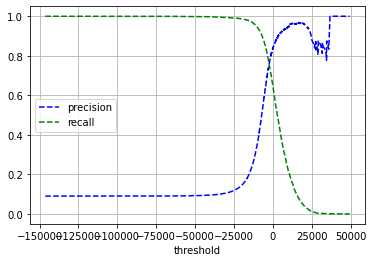

In [26]:
#정밀도 재현율 그리기

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="recall")
  plt.legend()
  plt.xlabel('threshold')
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문에 정밀도 곡선이 재현율 곡선보다 더 울퉁불퉁함

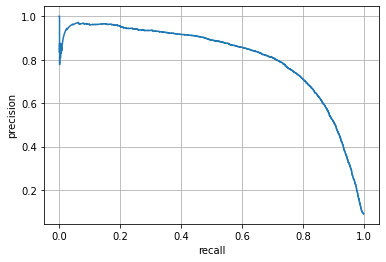

In [27]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하기 감소. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 ex) 재현율 60% 지점

In [28]:
# 정밀도 90% 달성이 목표라고 가정-> 임곗값 약 8000, 최소한 90% 정밀도가 되는 가장 낮은 임곗값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
#정밀도
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
#재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

3.3.5 ROC 곡선

- 수신기 조작 특성 (receiver operating characteristic, ROC) 곡선
- 거짓 양성 비율 (false positive rate, FPR)에 대한 진짜 양성 비율 (true positive rate, TPR, 재현율)의 곡선임
- FPR: 양성으로 잘못 분류된 음성 샘플의 비율로 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율 (true negative rate, TNR)을 뺀 값임
- TNR: 특이도 (specificity)라고도 함
- ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

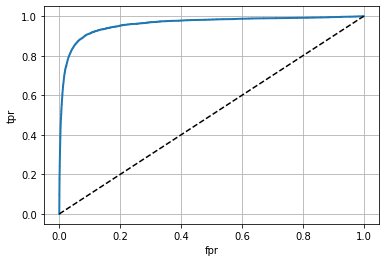

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

- tpr이 높을수록 fpr이 늘어남
- 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함
- 곡선 아래의 면적(AUC)를 측정하면 분류기들 비교 가능
- 완벽한 분류기는 1, 랜덤 분류기는 0.5

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
#RandomForestClassifier로 훈련
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
#양성 클래스에 대한 확률을 점수로 사용
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

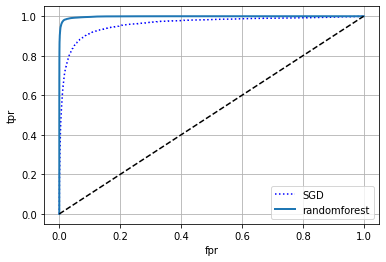

In [43]:
#ROC 곡선
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "randomforest")
plt.legend(loc="lower right")
plt.show()
# randomforet분류기가 SGD분류기보다 좋음

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3.4 다중 분류

다중분류기는 둘 이상의 클래스를 구별할 수 있음

- 로지스틱 회귀, 서포트 벡터 머신 분류기 같은 알고리즘은 이진 분류만 가능

- 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다! OvR, OvA, OvO

- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR, OvO 실행

In [46]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- 5를 구별한 타깃 클래스(y_train_5)대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해서 SVC훈련. 
- OvO이용해서 10개의 이진 분류기 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택

In [47]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
np.argmax(some_digit_scores) #5번째가 제일 높음

5

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
svm_clf.classes_[5]

5

In [51]:
#SVC 기반으로 OvR전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
#SGDClassifier훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- SGD는 직접 샘플을 다중 클래스로 분류할수 있기 때문에 ovr 이나 ovo적용할 필요 없엄

In [54]:
#sgd분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
#정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
#입력의 스케일 조정하여 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 3.5 에러 분석

- 모델의 성능을 향상 시킬 방법-> 에러 종류 분석

In [58]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

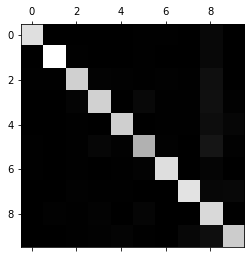

In [59]:
#이미지로 포현
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [60]:
#에러 비율 비교
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx= conf_mx/row_sums

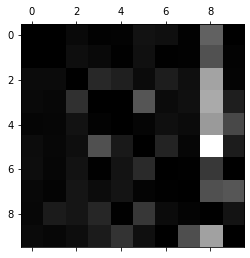

In [61]:
#주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

- 8열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시 -> 개선 필요!

ex) 동심원 수를 세는 알고리즘 (8은 2개, 6은 1개), 8처럼 보이는 훈련 데이터 더 많이 모아서 훈련
- 8행의 경우는 괜찮음-> 실제 8이 적절히 8로 분류

In [ ]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train ==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train ==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train ==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train ==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것임

### 다중 레이블 분류

: 여러개의 이진 꼬리표 출력

In [62]:
from sklearn.neighbors import KNeighborsClassifier

#각 숫자 이미지에 두 개의 타겟 레이블이 담긴 y_multilabel 배열을 만듦
y_train_large=(y_train>=7) #숫자가 큰 값 (7,8,9)인지 나타냄
y_train_odd=(y_train%2==1) #홀수인지 나타냄
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [64]:
#다중 레이블 분류기 평가 방법 중 1-> F1score의 평균 계산
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### 3.7 다중 출력 분류

- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것
- 즉, 값을 두 개 이상 가질 수 있음

예시) 이미지에서 잡음을 제거하는 시스템
- 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
- 분류기의 출력이 다중 레이블 (픽셀당 한 레이블)이고 각 레이블 값을 여러 개 가짐 (0부터 255까지 픽셀 강도)

In [65]:
#randint() 함수를 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)